Testing the analytic lhf with jake's prior

In [21]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import corner
import emcee

Define prior, log prob and log like

In [22]:
def lnprior(pars):
    m, b, s = pars
    if s < 0:
        return -np.inf
    else:
        return -1.5 * np.log(1 + b ** 2) - np.log(s)

In [23]:
def lnprob(pars, x, y, xerr, yerr):
    return lnprior(pars) + lnlike(pars, x, y, xerr, yerr)

In [24]:
def lnlike(pars, x, y, xerr, yerr):
    m, b, s = pars
    sig2 = (m*xerr)**2 + (yerr**2 + s**2)
    ll = -.5 * np.sum((m*x-y+b)**2/sig2 + np.log(sig2))
    return ll

In [25]:
def acorr_time(sampler_chain):
    nwalkers, nsteps, ndim = np.shape(sampler_chain)
    means = [np.mean([emcee.autocorr.integrated_time(sampler_chain[i, :, j]) \
                      for i in range(24)]) for j in range(ndim)]
    return means

In [26]:
def GR_diagnostic(sampler_chain):
    m, n, ndim = np.shape(sampler_chain)
    R_hats = np.zeros((ndim))

    for i in range(ndim):  # iterate over parameters
        
        # Define variables
        chains = sampler.chain[:, :, i] 
        flat_chain = samples[:, i]
        psi_dot_dot = np.mean(flat_chain)  
        psi_j_dot = np.mean(chains, axis=1)
        psi_j_t = chains

        # Calculate between-chain variance
        between = sum((psi_j_dot - psi_dot_dot)**2) / (m - 1)
    
        # Calculate within-chain variance
        inner_sum = np.sum(np.array([(psi_j_t[j, :] - psi_j_dot[j])**2 for j in range(m)]), axis=1)
        outer_sum = np.sum(inner_sum)
        W = outer_sum / (m*(n-1))

        # Calculate sigma
        sigma2 = (n-1)/n * W + between

        # Calculate convergence criterion (potential scale reduction factor)
        R_hats[i] = (m +1)*sigma2/(m*W) - (n-1)/(m*n)
    return R_hats

Load and plot the data

params =  -0.525509606298 1.31256220367


/Users/ruthangus/anaconda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


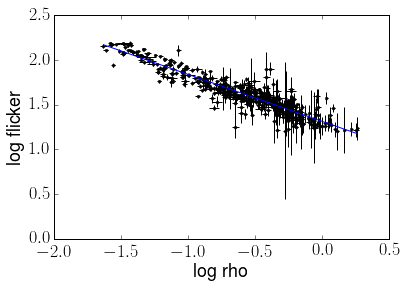

In [27]:
# load data
f, ferr, r, rerr = np.genfromtxt("../data/flickers.dat").T
r -= 3  # convert rho to g/cm^3

# fit a line
AT = np.vstack((r, np.ones_like(r)))
ATA = np.dot(AT, AT.T)
m, c = np.linalg.solve(ATA, np.dot(AT, f))
print("params = ", m, c)

# plot data with best fit line
xs = np.linspace(min(r), max(r), 100)
ys = m * xs + c
plt.errorbar(r, f, xerr=rerr, yerr=ferr, fmt="k.", capsize=0)
plt.plot(xs, ys)
plt.ylabel("log flicker")
plt.xlabel("log rho")

In [28]:
pars_init = [m, c, 0.06]
print(lnlike(pars_init, r, f, rerr, ferr)) # check the lhf works

875.180570019


In [29]:
ndim, nwalkers = 3, 24
pos = [pars_init + 1e-4 * np.random.randn(ndim) for i in range(nwalkers)]  # initialisation
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(r, f, rerr, ferr))
sampler.run_mcmc(pos, 30000)  # run MCMC
samples = sampler.chain[:, 29000:, :].reshape((-1, ndim))  # cut off burn in and flatten chains
m2, c2, sig2 = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]), zip(*np.percentile(samples, [16, 50, 84], axis=0)))

In [30]:
# save samples
import h5py
fi = h5py.File("rho_samples.h5", "w")
data = fi.create_dataset("samples", np.shape(sampler.chain))
data[:, :] = np.array(sampler.chain)
fi.close()

/Users/ruthangus/anaconda/lib/python3.5/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/Users/ruthangus/anaconda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


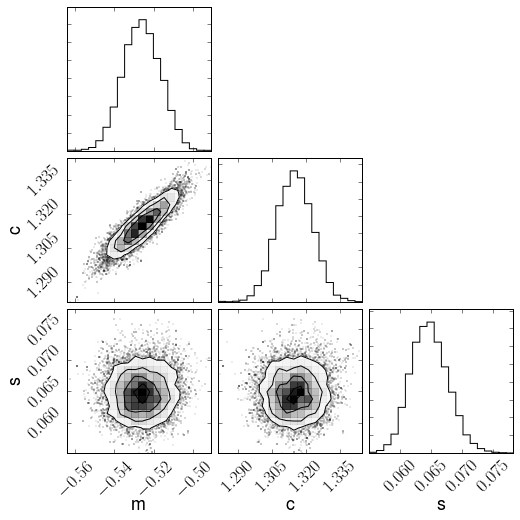

In [31]:
fig = corner.corner(samples, labels=["m", "c", "s"])

Calculate autocorrelation time and Gelman & Rubin convergence diagnostic

In [32]:
print(acorr_time(sampler.chain))
print(GR_diagnostic(sampler.chain))

[37.725919100977201, 37.726213827054615, 38.071815799744563]
[ 1.00126764  1.00098546  1.00344522]


Make figure for paper

In [33]:
plotpar = {'axes.labelsize': 18,
           'text.fontsize': 14,
           'legend.fontsize': 18,
           'xtick.labelsize': 18,
           'ytick.labelsize': 18,
           'text.usetex': True}
plt.rcParams.update(plotpar)

pink = "#FF33CC"
blue = "#0066CC"

/Users/ruthangus/anaconda/lib/python3.5/site-packages/matplotlib/__init__.py:855: UserWarning: text.fontsize is deprecated and replaced with font.size; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


/Users/ruthangus/anaconda/lib/python3.5/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/Users/ruthangus/anaconda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):
/Users/ruthangus/anaconda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


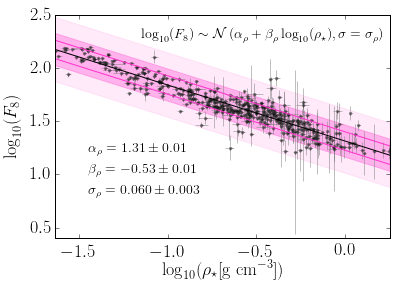

In [34]:
alpha, ap, am = c2
beta, bp, bm = m2
sigma, sp, sm = sig2
ys = m2[0] * xs + c2[0]
resids = f - m2[0] * r + c2[0]
plt.fill_between(xs, ys-2*np.std(resids)-2*sig2[0], ys+2*np.std(resids)+2*sig2[0], color=pink, alpha=.1)
plt.fill_between(xs, ys-np.std(resids)-sig2[0], ys+np.std(resids)+sig2[0], color=pink, alpha=.3)
plt.errorbar(r, f, xerr=rerr, yerr=ferr, fmt="k.", capsize=0, ecolor=".5", mec=".2", alpha=.5)
plt.plot(xs, ys, "k")
plt.plot(xs, ys-np.std(resids), color=pink)
plt.plot(xs, ys+np.std(resids), color=pink)
plt.ylabel("$\log_{10}(F_8)$")
plt.xlabel("$\log_{10}(\\rho_{\star}[\mathrm{g~cm}^{-3}])$")
#plt.text(-1.15, 2.25, "$\log_{10} (\\rho_{\star}) \sim \mathcal{N} \left(\\alpha_\\rho + \\beta_\\rho \log_{10}(F_8), \
#                \\sigma=\\sigma_{\\rho}\\right)$")
plt.text(-1.15, 2.25, "$\log_{10} (F_8) \sim \mathcal{N} \left(\\alpha_\\rho + \\beta_\\rho \log_{10}(\\rho_{\star}), \
                \\sigma=\\sigma_{\\rho}\\right)$")
plt.text(-1.45, 1.2, "$\\alpha_\\rho = %.2f \pm %.2f$" % (np.round(alpha, 2), np.round(ap, 2)))
plt.text(-1.45, 1., "$\\beta_\\rho = %.2f \pm %.2f $" % (np.round(beta, 2), np.round(bp, 2)))
plt.text(-1.45, .8, "$\\sigma_{\\rho} = %.3f \pm %.3f $" % (np.round(sigma, 2), np.round(sp, 3)))
plt.xlim(min(r), max(r))
plt.ylim(.4, 2.5)
plt.savefig("../version1.0/flicker_vs_rho.pdf")

Now with flicker vs logg

params =  -0.826618949099 4.90659568177


/Users/ruthangus/anaconda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


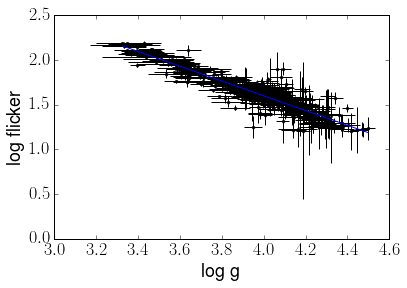

In [35]:
# load data
f, ferr, l, lerr, _, _ = np.genfromtxt("../data/log.dat").T

# fit a line
AT = np.vstack((l, np.ones_like(r)))
ATA = np.dot(AT, AT.T)
m, c = np.linalg.solve(ATA, np.dot(AT, f))
print("params = ", m, c)

# plot data with best fit line
xs = np.linspace(min(l), max(l), 100)
ys = m * xs + c
plt.errorbar(l, f, xerr=lerr, yerr=ferr, fmt="k.", capsize=0)
plt.plot(xs, ys)
plt.ylabel("log flicker")
plt.xlabel("log g")

In [36]:
pars_init = [m, c, 0.06]
ndim, nwalkers = 3, 24
pos = [pars_init + 1e-4 * np.random.randn(ndim) for i in range(nwalkers)]  # initialisation
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(l, f, rerr, ferr))
sampler.run_mcmc(pos, 30000)  # run MCMC
samples = sampler.chain[:, 29000:, :].reshape((-1, ndim))  # cut off burn in and flatten chains
m2, c2, sig2 = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]), zip(*np.percentile(samples, [16, 50, 84], axis=0)))

/Users/ruthangus/anaconda/lib/python3.5/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/Users/ruthangus/anaconda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


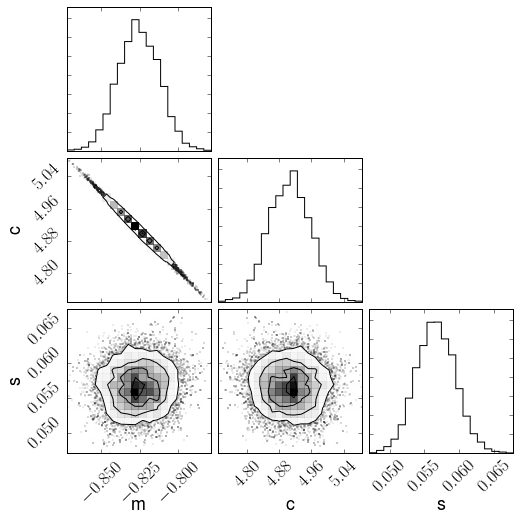

In [104]:
fig = corner.corner(samples, labels=["m", "c", "s"])

Calculate autocorrelation time and Gelman & Rubin convergence diagnostic

In [105]:
print(acorr_time(sampler.chain))
print(GR_diagnostic(sampler.chain))

[38.450524742039512, 38.484487660189984, 37.810884404861049]
[ 1.00620494  1.00669817  1.00211425]


/Users/ruthangus/anaconda/lib/python3.5/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/Users/ruthangus/anaconda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):
/Users/ruthangus/anaconda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


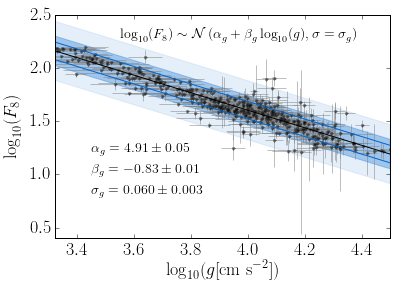

In [106]:
alpha, ap, am = c2
beta, bp, bm = m2
sigma, sp, sm = sig2
ys = m2[0] * xs + c2[0]
resids = f - m2[0] * l + c2[0]
plt.fill_between(xs, ys-2*np.std(resids)-2*sig2[0], ys+2*np.std(resids)+2*sig2[0], color=blue, alpha=.1)
plt.fill_between(xs, ys-np.std(resids)-sig2[0], ys+np.std(resids)+sig2[0], color=blue, alpha=.3)
plt.errorbar(l, f, xerr=lerr, yerr=ferr, fmt="k.", capsize=0, ecolor=".5", mec=".2", alpha=.5)
plt.plot(xs, ys, "k")
plt.plot(xs, ys-np.std(resids), color=blue)
plt.plot(xs, ys+np.std(resids), color=blue)
plt.ylabel("$\log_{10}(F_8)$")
plt.xlabel("$\log_{10}(g [\mathrm{cm~s}^{-2}])$")
plt.text(3.55, 2.25, "$\log_{10} (F_8) \sim \mathcal{N} \left(\\alpha_g + \\beta_g \log_{10}(g), \
                \\sigma=\\sigma_g\\right)$")
plt.text(3.45, 1.2, "$\\alpha_g = %.2f \pm %.2f$" % (np.round(alpha, 2), np.round(ap, 2)))
plt.text(3.45, 1., "$\\beta_g = %.2f \pm %.2f $" % (np.round(beta, 2), np.round(bp, 2)))
plt.text(3.45, .8, "$\\sigma_g = %.3f \pm %.3f $" % (np.round(sigma, 2), np.round(sp, 3)))
plt.xlim(min(l), max(l))
plt.ylim(.4, 2.5)
plt.savefig("../version1.0/flicker_vs_logg.pdf")

In [16]:
# save samples
fi = h5py.File("logg_samples.h5", "w")
data = fi.create_dataset("samples", np.shape(sampler.chain))
data[:, :] = np.array(sampler.chain)
fi.close()

# Calculating the Gelman \& Rubin convergence diagnostic

The Gelman and Rubin convergence diagnostic, or potential scale reduction factor (PSRF) can be written:

$$ \hat{R} = \frac{\hat{V}}{W} = \frac{m+1}{m} \frac{\hat{\sigma}_+^2}{W} - \frac{n-1}{mn}, $$

where $$ \hat{\sigma}_+^2 = \frac{n-1}{n}W + \frac{B}{n}, $$

$$ \frac{B}{n} = \frac{1}{m-1} \sum_{j=1}^m (\bar{\psi}_{j.} - \bar{\psi}_{..})^2, $$ the between-sequence variance and

$$ W = \frac{1}{m(n-1)} \sum_{j=1}^m \sum_{t=1}^n (\psi_{jt} - \bar{\psi}_{j.})^2, $$ the within-sequence variance.

$n$ is the number of steps, $m$ is the number of chains and $\psi$ is a random variable, $\alpha$ for example. $\psi_{..}$ is the mean.

In [57]:
chains = sampler.chain[:, :, 0]  # 0 for alpha
m, n = np.shape(chains)  # m is number of chains, n is number of steps
flat_chain = samples[:, 0] # 0 for alpha

In [58]:
psi_dot_dot = np.mean(flat_chain)  
psi_j_dot = np.mean(chains, axis=1)

In [59]:
between = sum((psi_j_dot - psi_dot_dot)**2) / (m - 1)
B = between * n
print("B/N =", between)

B/N = 3.06648255146e-07


In [60]:
psi_j_t = chains
inner_sum = np.sum(np.array([(psi_j_t[i, :] - psi_j_dot[i])**2 for i in range(m)]), axis=1)
outer_sum = np.sum(inner_sum)
W = outer_sum / (m*(n-1))
print("W = ", W)

W =  0.000170458291169


In [61]:
sigma2 = (n-1)/n * W + between
print("sigma2 = ", sigma2)

sigma2 =  0.00017075641651


In [62]:
R_hat = (m +1)*sigma2/(m*W) - (n-1)/(m*n)
print("R_hat = ", R_hat)

R_hat =  1.00182392038


"If $\hat{R}$ is large, this suggests that either estimate of the
variance $\hat{\sigma}^2$ can be further decreased by more simulations, or that further simulation will
increase $W$, since the simulated sequences have not yet made a full tour of the target
distribution. Alternatively, if the PSRF is close to 1, we can conclude that each of the
$m$ sets of $n$ simulated observations is close to the target distribution. "

In [71]:
acf = emcee.autocorr.function(sampler.chain[0, :, 0])

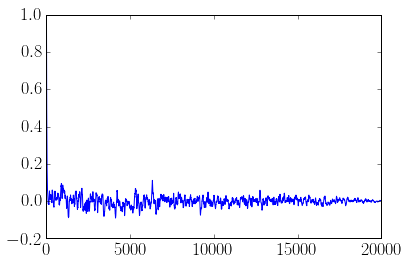

In [72]:
plt.plot(acf)